In [167]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [825]:
class NaiveBayesClassifier():
    '''
    Bayes Theorem form
    P(y|X) = P(X|y) * P(y) / P(X)
    '''
    def calc_prior(self, features, target):
        '''
        prior probability P(y)
        calculate prior probabilities
        '''
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()

        return self.prior
    
    def calc_statistics(self, features, target):
        '''
        calculate mean, variance for each column and convert to numpy array
        ''' 
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
              
        return self.mean, self.var
    
    def gaussian_density(self, class_idx, x):     
        '''
        calculate probability from gaussian density function (normally distributed)
        we will assume that probability of specific target value given specific class is normally distributed 
        
        probability density function derived from wikipedia:
        (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²)), where μ is mean, σ² is variance, σ is quare root of variance (standard deviation)
        '''
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
#         numerator = np.exp(-((x-mean)**2 / (2 * var)))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob
    
    def calc_posterior(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for i in range(self.count):
            prior = np.log(self.prior[i]) ## use the log to make it more numerically stable
            conditional = np.sum(np.log(self.gaussian_density(i, x))) # use the log to make it more numerically stable
            posterior = prior + conditional
            posteriors.append(posterior)
        # return class with highest posterior probability
        return self.classes[np.argmax(posteriors)]
     

    def fit(self, features, target):
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        
        self.calc_statistics(features, target)
        self.calc_prior(features, target)
        
    def predict(self, features):
        preds = [self.calc_posterior(f) for f in features.to_numpy()]
        return preds

    def accuracy(self, y_test, y_pred):
        accuracy = np.sum(y_test == y_pred) / len(y_test)
        return accuracy

    def visualize(self, y_true, y_pred, target):
        
        tr = pd.DataFrame(data=y_true, columns=[target])
        pr = pd.DataFrame(data=y_pred, columns=[target])
        
        
        fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))
        
        sns.countplot(x=target, data=tr, ax=ax[0], palette='viridis', alpha=0.7, hue=target, dodge=False)
        sns.countplot(x=target, data=pr, ax=ax[1], palette='viridis', alpha=0.7, hue=target, dodge=False)
        

        fig.suptitle('True vs Predicted Comparison', fontsize=20)

        ax[0].tick_params(labelsize=12)
        ax[1].tick_params(labelsize=12)
        ax[0].set_title("True values", fontsize=18)
        ax[1].set_title("Predicted values", fontsize=18)
        plt.show()


In [826]:

# pre-process dataset for training 

# upload Iris dataset -  shape is (150, 5)
df = pd.read_csv("data/iris.csv")
# shuffle dataset with sample
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
# df shape
print(df.shape)
# set features and target
X, y = df.iloc[:, :-1], df.iloc[:, -1]


# # split on train and test 0.7/0.3
X_train, X_test, y_train, y_test = X[:100], X[100:], y[:100], y[100:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(150, 5)
(100, 4) (100,)
(50, 4) (50,)


In [807]:
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.8,4.0,1.2,0.2,Setosa
1,5.1,2.5,3.0,1.1,Versicolor
2,6.6,3.0,4.4,1.4,Versicolor
3,5.4,3.9,1.3,0.4,Setosa
4,7.9,3.8,6.4,2.0,Virginica
...,...,...,...,...,...
145,6.3,2.8,5.1,1.5,Virginica
146,6.4,3.1,5.5,1.8,Virginica
147,6.3,2.5,4.9,1.5,Versicolor
148,6.7,3.1,5.6,2.4,Virginica


In [808]:
X_train.shape

(100, 4)

In [809]:
x.classes, x.feature_nums, x.rows, x.count

(array(['Setosa', 'Versicolor', 'Virginica'], dtype=object), 4, 100, 3)

In [810]:
x.calc_prior(X_train, y_train)

array([0.31, 0.32, 0.37])

In [811]:
x.prior

array([0.31, 0.32, 0.37])

In [812]:

x.calc_statistics(X_train, y_train)

(array([[5.08387097, 3.50322581, 1.46129032, 0.24516129],
        [5.9125    , 2.790625  , 4.275     , 1.33125   ],
        [6.71891892, 2.98918919, 5.63243243, 2.05675676]]),
 array([[0.11361082, 0.10934443, 0.02430801, 0.0089282 ],
        [0.21296875, 0.08272461, 0.185625  , 0.03214844],
        [0.3566691 , 0.11339664, 0.32867787, 0.0592111 ]]))

In [785]:
x.mean

array([[5.08387097, 3.50322581, 1.46129032, 0.24516129],
       [5.9125    , 2.790625  , 4.275     , 1.33125   ],
       [6.71891892, 2.98918919, 5.63243243, 2.05675676]])

In [786]:
x.var

array([[0.11361082, 0.10934443, 0.02430801, 0.0089282 ],
       [0.21296875, 0.08272461, 0.185625  , 0.03214844],
       [0.3566691 , 0.11339664, 0.32867787, 0.0592111 ]])

In [787]:
X_train

,sepal.length,sepal.width,petal.length,petal.width
0,5.8,4.0,1.2,0.2
1,5.1,2.5,3.0,1.1
2,6.6,3.0,4.4,1.4
3,5.4,3.9,1.3,0.4
4,7.9,3.8,6.4,2.0
...,...,...,...,...
95,6.7,3.0,5.2,2.3
96,6.3,2.3,4.4,1.3
97,6.2,3.4,5.4,2.3
98,7.2,3.6,6.1,2.5


In [827]:
# train the model
x = NaiveBayesClassifier()


x.fit(X_train, y_train)

In [828]:
predictions = x.predict(X_test)

In [829]:
x.accuracy(y_test, predictions)

0.92

In [830]:
y_test.value_counts(normalize=True)

Setosa        0.38
Versicolor    0.36
Virginica     0.26
Name: variety, dtype: float64

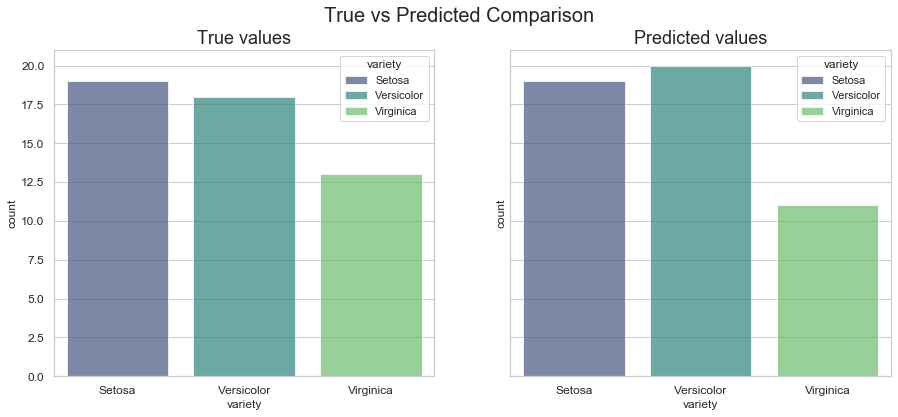

In [831]:
x.visualize(y_test, predictions, 'variety')

In [832]:
# Sentiment Analysis with Naive Bayes 

In [853]:
emails = pd.read_csv("data/spambase.data")

In [854]:
emails.head(2)

,0,0.64,0.64.1,0.1,0.32,0.2,0.3,0.4,0.5,0.6,...,0.40,0.41,0.42,0.778,0.43,0.44,3.756,61,278,1
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1


In [856]:
emails['1'].value_counts()

0    2788
1    1812
Name: 1, dtype: int64

In [857]:
emails['spam'] = emails['1']
emails = emails.drop(columns=['1'])
emails['spam'] = emails['spam'].map({1: "spam", 0: "not_spam"}) 

In [858]:
emails['spam'].value_counts()

not_spam    2788
spam        1812
Name: spam, dtype: int64

In [836]:
print(emails.shape)
emails.head()

(4600, 58)


,0,0.64,0.64.1,0.1,0.32,0.2,0.3,0.4,0.5,0.6,...,0.40,0.41,0.42,0.778,0.43,0.44,3.756,61,278,spam
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,spam
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,spam
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,spam
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,spam
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,spam


In [837]:
X,y = emails.iloc[:, :-1], emails.iloc[:, -1]

In [838]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [839]:
model = NaiveBayesClassifier()

In [840]:
model.fit(X_train, y_train)

In [841]:
preds = model.predict(X_test)

c:\users\tigju\anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log


In [851]:
y_train

2194    not_spam
958         spam
1533        spam
654         spam
1497        spam
          ...   
4426    not_spam
466         spam
3092    not_spam
3772    not_spam
860         spam
Name: spam, Length: 3220, dtype: object

In [842]:
model.accuracy(y_test, preds)

0.7862318840579711

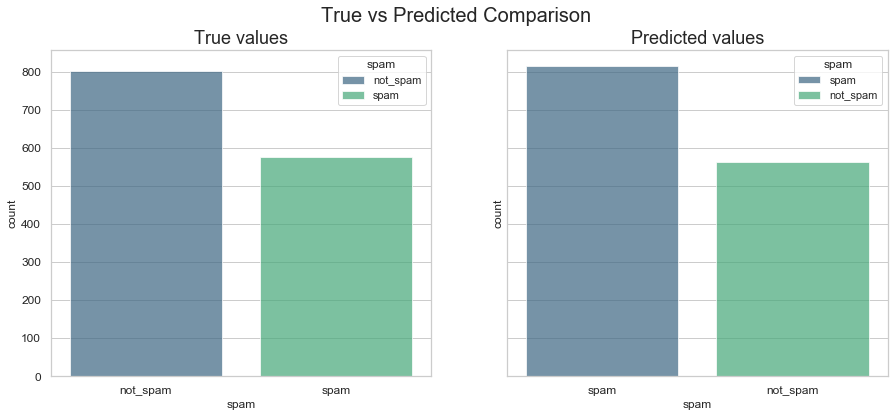

In [843]:
model.visualize(y_test, preds, 'spam')

In [737]:
# compare to sklearn Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


In [738]:
clf = GaussianNB()

In [557]:
# iris dataset
clf.fit(X_train, y_train)

GaussianNB()

In [558]:
preds = clf.predict(X_test)

In [559]:
clf.score(X_test, y_test)

0.92

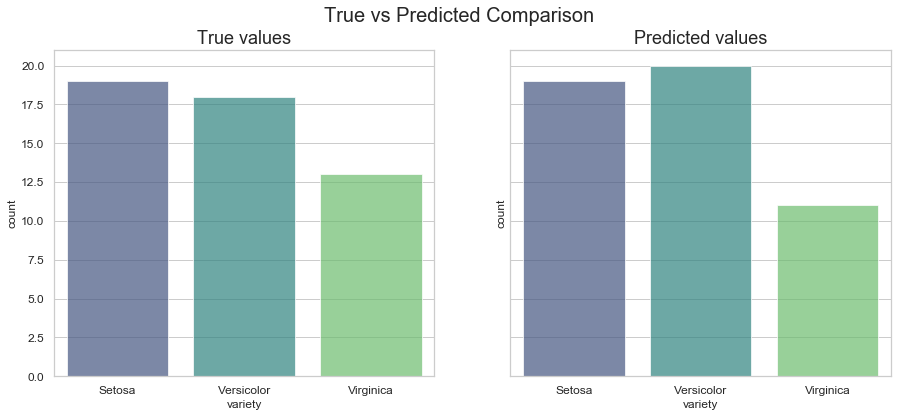

In [562]:
tr = pd.DataFrame(data=y_test, columns=['variety'])
pr = pd.DataFrame(data=preds, columns=['variety'])


fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))

sns.countplot(x='variety', data=tr, ax=ax[0], palette='viridis', alpha=0.7)
sns.countplot(x='variety', data=pr, ax=ax[1], palette='viridis', alpha=0.7)


fig.suptitle('True vs Predicted Comparison', fontsize=20)

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
ax[0].set_title("True values", fontsize=18)
ax[1].set_title("Predicted values", fontsize=18)
plt.show()

In [844]:
#emails dataset 
clf1 = GaussianNB()

In [845]:
clf1.fit(X_train, y_train)

GaussianNB()

In [846]:
preds1 = clf1.predict(X_test)

In [847]:
# prediced better for emails classifications
clf1.score(X_test, y_test)

0.8181159420289855

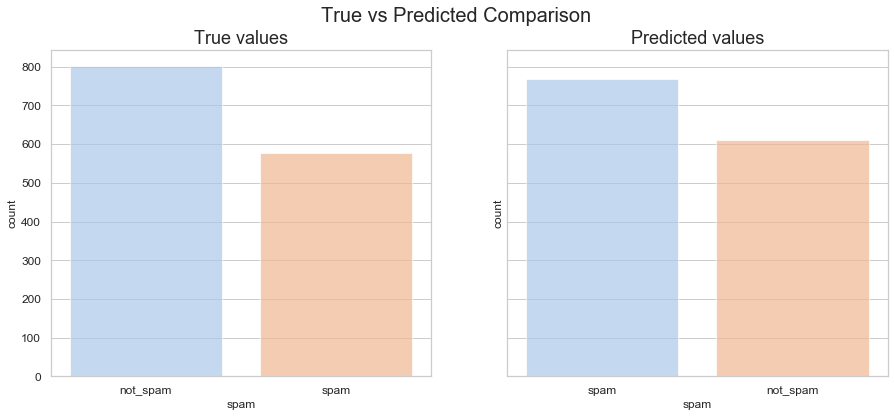

In [848]:
test_df = pd.DataFrame(data=y_test, columns=['spam'])
pred_df = pd.DataFrame(data=preds1, columns=['spam'])
    
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))
        
sns.countplot(x='spam', data=test_df, ax=ax[0], palette='pastel', alpha=0.7)
sns.countplot(x='spam', data=pred_df, ax=ax[1], palette='pastel', alpha=0.7)


fig.suptitle('True vs Predicted Comparison', fontsize=20)

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
ax[0].set_title("True values", fontsize=18)
ax[1].set_title("Predicted values", fontsize=18)
plt.show()